Epoch 1/10
4/4 [==============================] - 15s 3s/step - loss: 19472.1934 - accuracy: 0.5702 - val_loss: 721.9837 - val_accuracy: 0.7931
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 7037.9902 - accuracy: 0.8333 - val_loss: 9182.8018 - val_accuracy: 0.8621
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 6651.5977 - accuracy: 0.8772 - val_loss: 3073.8494 - val_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 11s 3s/step - loss: 5154.0605 - accuracy: 0.7982 - val_loss: 7039.5669 - val_accuracy: 0.8966
Epoch 5/10
4/4 [==============================] - 10s 3s/step - loss: 6653.3647 - accuracy: 0.9123 - val_loss: 2175.1272 - val_accuracy: 0.9310
Epoch 6/10
4/4 [==============================] - 10s 3s/step - loss: 2437.8257 - accuracy: 0.8158 - val_loss: 573.2147 - val_accuracy: 0.9655
Epoch 7/10
4/4 [==============================] - 10s 3s/step - loss: 1166.5656 - accuracy: 0.9298 - val_loss: 45.7889 - val_accuracy: 0.

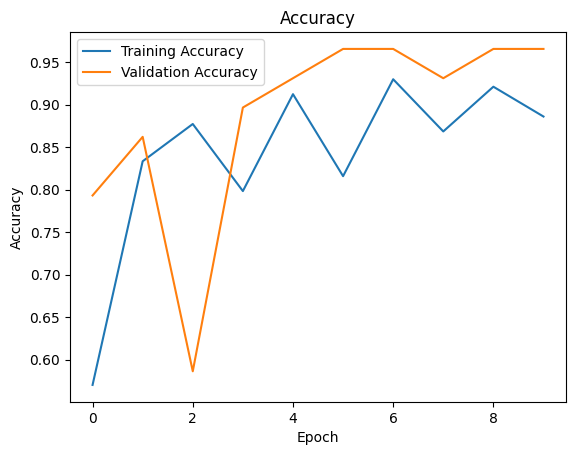

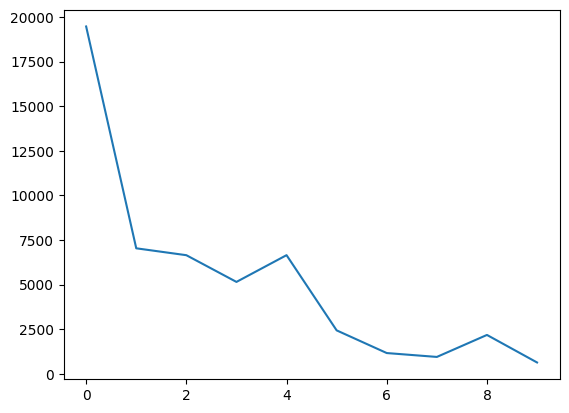

In [1]:
import numpy as np
import librosa
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define function to extract features from audio signal
def extract_features(file_path, max_pad_len=500):
    X, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(X)), ref=np.max)
    pad_width = max_pad_len - mfccs.shape[1]
    pad_width1 = max_pad_len - spectrogram.shape[1] 
    if pad_width < 0:
        mfccs = mfccs[:, :max_pad_len]
        spectrogram = spectrogram[:, :max_pad_len]
    else:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        spectrogram = np.pad(spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
    combined_features = np.concatenate((mfccs.flatten(), spectrogram.flatten()))
    return combined_features

# Load positive and negative datasets
positive_dir = "./positive/positive/"
negative_dir = "./negative/negative/"

positive_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.wav')]
negative_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.wav')]

X = []
y = []
for file_path in positive_files:
    X.append(extract_features(file_path))
    y.append(1)
for file_path in negative_files:
    X.append(extract_features(file_path))
    y.append(0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data to tensors
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate model on testing set
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Use model to classify new audio signals
new_file_path = "./test.wav"
features = extract_features(new_file_path)
prediction = model.predict(np.expand_dims(features, axis=0))
if prediction > 0.5:
    print("Scream detected")
else:
    print("No scream detected")

# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')

In [3]:
from sklearn.metrics import classification_report

# Use model to predict on test set
y_pred = model.predict(X_test)

# Print precision, recall, f1-score for each class
target_names = ['Negative', 'Positive']
print("Classification report of KNN")
print(classification_report(y_test, y_pred, target_names=target_names))

1/1 [==============================] - 0s 147ms/step
Classification report of KNN
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96        12
    Positive       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29

